In [1]:
import pandas as pd
import numpy as np
from gravity_utils import *
import datetime

In [2]:
pd.set_option('display.max_rows', 1398)
pd.set_option('display.max_columns', 1398)

In [3]:
import shapefile
import shapely.wkt

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
import stat
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, log_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso

In [5]:
def print_stats (model, X, y):
    """Prints coefficients, t-values and probabilities P value?"""
    lm = model
#     params = np.append(lm.intercept_,lm.coef_)
    params = lm.coef_
    predictions = lm.predict(X)

    # newX = pd.DataFrame({"Constant":np.ones(len(X))}, index = X.index).join(pd.DataFrame(X))
#     newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    newX = pd.DataFrame(X.reset_index(drop=True))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,5)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
#     myDF3.index = np.append(['intercept_'], X.columns.values)
    myDF3.index = X.columns.values
    print(myDF3)

In [6]:
sams_w_nbuildings = pd.read_csv('data/GIS/B1_samsSW_20131231_shp/B1_sams_with_nbuildings.csv', sep=';', index_col=0)
sams_w_nbuildings['SAMSCODE'] = sams_w_nbuildings.SAMSCODE.astype(int)
sams_w_nbuildings['KOMMUN'] = sams_w_nbuildings.KOMMUN.astype(int)

In [7]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
upsampled_resfil = draw_population(resfil_raw, resfil_raw.individvikt.astype(int))
upsampled_resfil = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1)] 

# attraction_rvu = upsampled_resfil[(upsampled_resfil['rf4_komkod'] < 2000) &
#                                     (upsampled_resfil['rf4_komkod'] > 100)].groupby('rf4_komkod')['Id'].count()
# production_rvu = upsampled_resfil[(upsampled_resfil['rf1_komkod'] < 2000) &
#                                     (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

# production_rvu_sams = upsampled_resfil[(upsampled_resfil['rf1_komkod'] < 2000) &
#                                     (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
# attraction_rvu_sams = upsampled_resfil[(upsampled_resfil['rf4_komkod'] < 2000) &
#                                     (upsampled_resfil['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [8]:
resfil_tours_raw = resfil_raw[resfil_raw['ärende_2'] == 1].drop_duplicates(subset=['Id'], keep='first')
upsampled_resfil_tours = draw_population(resfil_tours_raw, resfil_tours_raw.individvikt.astype(int))

attraction_rvu = upsampled_resfil_tours[(upsampled_resfil_tours['rf4_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf4_komkod'] > 100)].groupby('rf4_komkod')['Id'].count()
production_rvu = upsampled_resfil_tours[(upsampled_resfil_tours['rf1_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

production_rvu_sams = upsampled_resfil_tours[(upsampled_resfil_tours['rf1_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
attraction_rvu_sams = upsampled_resfil_tours[(upsampled_resfil_tours['rf4_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [9]:
production_raw_rvu = resfil_tours_raw[(resfil_tours_raw['ärende_2'] == 1) &
                                (resfil_tours_raw['rf1_komkod'] < 2000) &
                                (resfil_tours_raw['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
attraction_raw_rvu = resfil_tours_raw[(resfil_tours_raw['ärende_2'] == 1) &
                                (resfil_tours_raw['rf4_komkod'] < 2000) &
                                (resfil_tours_raw['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [10]:
rvu_vs_scb = pd.DataFrame([production_raw_rvu, 
                           sams_w_nbuildings.set_index('SAMSCODE').TotBef, 
                           production_raw_rvu / sams_w_nbuildings.set_index('SAMSCODE').TotBef,
                           production_rvu_sams
                          ], 
             index=['rvu', 'sams', 'ratio', 'upsampled_rvu']).T.sort_values(['ratio'], ascending=False)

# sams_ids = rvu_vs_scb[(rvu_vs_scb['ratio'] < 10) & (rvu_vs_scb['ratio'] > 0.03) & (rvu_vs_scb['rvu'] > 5)]
# sams_index = sams_ids.index
sams_index = sams_w_nbuildings.SAMSCODE.values

In [11]:
a2 = read_shapefile('data/GIS/A2_samsSW_2012_shp/A2_sw_region.shp')
a2['KOMMUN'] = a2.KOMMUN.astype(int)
a2['SAMSCODE'] = a2.SAMSCODE.astype(int)
night_pop = a2[(a2.KOMMUN > 1200) & (a2.KOMMUN < 1300)]
# target_night_pop = night_pop.loc[(night_pop.KOMMUN == 1265) | (night_pop.KOMMUN == 1270)]
target_night_pop = night_pop.set_index('SAMSCODE').loc[sams_index].reset_index()
target_night_pop = target_night_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']
# other_night_pop = night_pop.loc[(night_pop.KOMMUN != 1265) & (night_pop.KOMMUN != 1270)]
other_night_pop = night_pop
other_night_pop = other_night_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']

a4 = read_shapefile('data/GIS/A4_samsSW_2012_shp/A4_sw_region.shp')
a4['KOMMUN'] = a4.KOMMUN.astype(int)
a4['SAMSCODE'] = a4.SAMSCODE.astype(int)
a4 = a4[(a4.KOMMUN > 1200) & (a4.KOMMUN < 1300)]
target_day_pop = a4.set_index('SAMSCODE').loc[sams_index].reset_index()
# target_day_pop = a4.loc[(a4.KOMMUN == 1265) | (a4.KOMMUN == 1270)]
target_day_pop = target_day_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']
other_day_pop = a4
# other_day_pop = a4.loc[(a4.KOMMUN != 1265) & (a4.KOMMUN != 1270)]
other_day_pop = other_day_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']

# target_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN == 1265) | (sams_w_nbuildings.KOMMUN == 1270)]
target_buildings = sams_w_nbuildings.set_index('SAMSCODE').loc[sams_index].reset_index()
target_buildings = target_buildings.groupby(['SAMSCODE']).sum()
# other_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN != 1265) & (sams_w_nbuildings.KOMMUN != 1270)]
other_buildings = sams_w_nbuildings
other_buildings = other_buildings.groupby(['KOMMUN']).sum()

#buildings = sams_w_nbuildings.groupby(['SAMSCODE'])['nProduction', 'nAttraction','TotBef', 'small_building', 'appt_build', 'multi_appartment_building'].sum()

In [12]:
production_sams_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
production_kommun_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

In [13]:
target_x_sams = pd.concat([target_night_pop, target_buildings, target_day_pop], axis=1).sort_index()
other_x_sams = pd.concat([other_night_pop, other_buildings, other_day_pop], axis=1).sort_index()

all_x_sams = pd.concat([target_x_sams, other_x_sams]).sort_index()

# all_y_prod = pd.concat([target_night_pop, other_night_pop])
# all_y_att = pd.concat([target_day_pop, other_day_pop])

kommun_rvu_prod = production_kommun_rvu.sort_index()
sams_rvu_prod = production_sams_rvu.loc[sams_index].sort_index()

all_y_prod = pd.concat([kommun_rvu_prod, sams_rvu_prod]).sort_index()

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


In [14]:
other_trip_scb_2018 = pd.read_csv('data/coomuting_municipalities_2018.csv', sep=';', header=[0], index_col=[0])
other_trip_scb_2018['production'] = other_trip_scb_2018['Outgoing commuters'] + other_trip_scb_2018['Work and live in county/municipality']
other_trip_scb_2018['attraction'] = other_trip_scb_2018['Incomming commuters'] + other_trip_scb_2018['Work and live in county/municipality']
other_trip_scb_2003 = pd.read_csv('data/coomuting_municipalities_2013.csv', sep=';', header=[0], index_col=[0])
other_trip_scb_2003['production'] = other_trip_scb_2003['Comuters leaving the municipality'] + other_trip_scb_2003['Working and living in the municipality']
other_trip_scb_2003['attraction'] = other_trip_scb_2003['Comuters coming into the municipality'] + other_trip_scb_2003['Working and living in the municipality']

In [15]:
other_trip_scb_2003 = other_trip_scb_2003.dropna()
other_trip_scb_2018 = other_trip_scb_2018.dropna()

In [16]:
other_trip_scb_raw = \
pd.concat([other_trip_scb_2018.production - (other_trip_scb_2018.production - other_trip_scb_2003.production)*5/15,
           other_trip_scb_2018.attraction - (other_trip_scb_2018.attraction - other_trip_scb_2003.attraction)*5/15,
           other_trip_scb_2018['Outgoing commuters'] - (other_trip_scb_2018['Outgoing commuters'] - other_trip_scb_2003['Comuters leaving the municipality'])*5/15,
           other_trip_scb_2018['Incomming commuters'] - (other_trip_scb_2018['Incomming commuters'] - other_trip_scb_2003['Comuters coming into the municipality'])*5/15,
           other_trip_scb_2018['Work and live in county/municipality'] - (other_trip_scb_2018['Work and live in county/municipality'] - other_trip_scb_2003['Working and living in the municipality'])*5/15,
          ],
         axis=1)
other_trip_scb_raw.columns=['production', 'attraction', 'outgoing', 'incomming', 'within']

In [17]:
other_trip_scb_raw

,production,attraction,outgoing,incomming,within
County/Municipality,,,,,
1214,6420.666667,3998.666667,4008.333333,1586.333333,2412.333333
1230,11115.000000,6318.333333,8450.666667,3654.000000,2664.333333
1231,7476.333333,8257.000000,5501.000000,6281.666667,1975.333333
1233,16125.333333,8499.000000,11189.666667,3563.333333,4935.666667
1256,6280.333333,4848.666667,2911.333333,1479.666667,3369.000000
1257,4457.000000,3883.000000,1910.333333,1336.333333,2546.666667
1260,6609.333333,4803.666667,4040.666667,2235.000000,2568.666667
1261,14433.333333,7940.000000,9982.666667,3489.333333,4450.666667
1262,10470.000000,5527.000000,8099.000000,3156.000000,2371.000000


In [18]:
avg_day_c = production_kommun_rvu.sum() / other_trip_scb_raw.production.sum()
avg_day_c
other_trip_scb = other_trip_scb_raw*avg_day_c

In [19]:
avg_day_c

0.651633045730121

# Production linear regression

In [20]:
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

# lin = LinearRegression(fit_intercept=False, )

x_prod = other_x_sams.drop(axis=1, labels=['OffentligaA4','Ald25_44','TotBef', 'appt_build','multi_appartment_building','small_building','Ald65_W','Ald45_64','TotaltA2','Ald20_24','nIndustri','nEkonomi','TotaltA4','Ald16_19','Ald7_15','Ald0_6','nProduction','nAttraction','SAMSCODE'])
y_prod = other_trip_scb.production

# x_prod = other_x_sams.drop(axis=1, labels=['Ald20_24','TotBef','Ald65_W','Ald7_15','multi_appartment_building','nEkonomi','nIndustri','nProduction','appt_build','nAttraction','Ald16_19','Ald0_6','SAMSCODE', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'TotaltA4', 'OffentligaA4', 'NaringslivA4'])
# y_prod = other_night_pop.TotaltA2

# x_prod = x_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])
# y_prod = y_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])

scaler_prod = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_prod.fit(x_prod)

X_prod = pd.DataFrame(scaler_prod.transform(x_prod), columns=x_prod.columns, index=x_prod.index)
production_model = lin.fit(X_prod, y_prod)
train_prod_pred = production_model.predict(X_prod)
score = r2_score(y_prod, train_prod_pred)
print('R**2 value')
print(score)
# print(pd.DataFrame(production_model.coef_, index=X_prod.columns))
print_stats(production_model, X_prod, y_prod)

R**2 value
0.9998860706634678
              Coefficients  Standard Errors  t values  Probabilites
OffentligaA2        0.5158            0.018    28.324       0.00000
NaringslivA2        0.6993            0.010    68.610       0.00000
NaringslivA4        0.0372            0.008     4.939       0.00002


In [21]:
pred_prod_sams = pd.DataFrame(
    production_model.predict(scaler_prod.transform(target_x_sams.loc[:, X_prod.columns])), 
    index=target_x_sams.index,
    columns=['trips']
)

In [22]:
pred_prod_sams.describe()

,trips
count,1397.000000
mean,271.495619
std,291.146924
min,0.000000
25%,66.158824
50%,184.282246
75%,371.860304
max,2377.125475


In [23]:
kommun_to_sams = sams_w_nbuildings.groupby(['KOMMUN'])['SAMSCODE'].unique()
predicted_kommun_trips_from_sams = \
    pd.DataFrame([pred_prod_sams.loc[samses].sum().values for _, samses in kommun_to_sams.iteritems()], 
                 index=kommun_to_sams.index, columns=['trips_sams'])
predicted_kommun_trips_from_sams = predicted_kommun_trips_from_sams.join(other_trip_scb.production)

In [24]:
r2_score(predicted_kommun_trips_from_sams.trips_sams, predicted_kommun_trips_from_sams.production)

0.9998854928896254

In [25]:
(predicted_kommun_trips_from_sams.trips_sams / predicted_kommun_trips_from_sams.production).describe()

count    33.000000
mean      1.012254
std       0.020275
min       0.986399
25%       0.997900
50%       1.008151
75%       1.021808
max       1.056983
dtype: float64

# Attraction Linear regression

In [26]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

x_att = other_x_sams.drop(axis=1, labels=['TotBef', 'SAMSCODE', 'Ald0_6', 'nProduction', 'nAttraction', 'multi_appartment_building', 'small_building', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'Ald7_15', 'Ald16_19', 'Ald20_24','appt_build', 'Ald65_W', 'Ald45_64','TotaltA4', 'nEkonomi'])
y_att = other_trip_scb.attraction

# x_att = x_att.drop(labels=[1280,1281,1283,1290,1292, 1293])
# y_att = y_att.drop(labels=[1280,1281,1283,1290,1292, 1293])

# x_att_s = x_att.append(pd.DataFrame(np.zeros(len(x_att.columns)), index=x_att.columns).T)
scaler_att = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_att.fit(x_att)

X_att = pd.DataFrame(scaler_att.transform(x_att), columns=x_att.columns, index=x_att.index)
attraction_model = lin.fit(X_att, y_att)
train_att_pred = attraction_model.predict(X_att)
score = r2_score(y_att, train_att_pred)
print('R**2 value')
print(score)
print_stats(attraction_model, X_att, y_att)

R**2 value
0.9997709289511443
              Coefficients  Standard Errors  t values  Probabilites
Ald25_44            0.2051            0.029     7.003       0.00000
nIndustri           0.9510            0.197     4.833       0.00003
OffentligaA4        0.6471            0.025    25.617       0.00000
NaringslivA4        0.5360            0.026    20.234       0.00000


In [27]:
pred_att_sams = pd.DataFrame(
    attraction_model.predict(scaler_att.transform(target_x_sams.loc[:, X_att.columns])), 
    index=target_x_sams.index,
    columns=['trips']
)
pred_att_sams.describe()

,trips
count,1397.000000
mean,267.022473
std,454.666141
min,0.000000
25%,52.485378
50%,133.370841
75%,310.093441
max,5985.384590


In [28]:
pred_att_sams.loc[12650000:12659999].sum()

trips    4208.86583
dtype: float64

In [29]:
y_att[1265]

3975.3960009842253

In [30]:
pred_prod_sams.loc[12650000:12659999].sum()

trips    5962.677432
dtype: float64

In [31]:
y_prod[1265]

5729.157738059224

In [32]:
kommun_to_sams = sams_w_nbuildings.groupby(['KOMMUN'])['SAMSCODE'].unique()
predicted_kommun_trips_from_sams = \
    pd.DataFrame([pred_att_sams.loc[samses].sum().values for _, samses in kommun_to_sams.iteritems()], 
                 index=kommun_to_sams.index, columns=['trips_sams'])
predicted_kommun_trips_from_sams = predicted_kommun_trips_from_sams.join(other_trip_scb.attraction)

In [33]:
r2_score(predicted_kommun_trips_from_sams.trips_sams, predicted_kommun_trips_from_sams.attraction)

0.9997693393236631

In [34]:
(predicted_kommun_trips_from_sams.trips_sams / predicted_kommun_trips_from_sams.attraction).describe()

count    33.000000
mean      1.028054
std       0.052064
min       0.906502
25%       0.986583
50%       1.033069
75%       1.064003
max       1.153474
dtype: float64

# Gravity model for municipalities

# Gravity

In [35]:
sams_distance_matrix = pd.read_csv('data/sams_distance_matrix_osrm.csv', sep=';', index_col=[0])
sams_distance_matrix.columns = sams_distance_matrix.index
#the thing above is differently sorted
sams_distance_matrix = sams_distance_matrix.sort_index().T.sort_index().T

In [36]:
# sams_distance_matrix.replace(0, np.nan, inplace=True)
# for (idx, value) in sams_distance_matrix.loc[1200:1299, 1200:1299].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[[1273, 1291], [1273, 1291]].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 2)

# sams_distance_matrix.at[12650001, 12650002] = sams_distance_matrix.loc[12650001].min() * (1.0 / 3)
# sams_distance_matrix.at[12650002, 12650001] = sams_distance_matrix.loc[12650002].min() * (1.0 / 3)
# sams_distance_matrix.at[12700020, 12700001] = sams_distance_matrix.loc[12700020].min() * (1.0 / 3)
# sams_distance_matrix.at[12700001, 12700020] = sams_distance_matrix.loc[12700001].min() * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[12650000:12659999, 12650000:12659999].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[12700000:12709999, 12700000:12709999].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)

sams_distance_matrix.replace(0, np.nan, inplace=True)
r = 2000
r1 = 2000
for (idx, value) in sams_distance_matrix.min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = value


In [37]:
sams_distance_matrix = sams_distance_matrix.replace(0, r)
sams_distance_matrix = sams_distance_matrix.replace(np.NaN, r)

In [38]:
sams_distance_matrix = sams_distance_matrix.replace(-0.2, r)
sams_distance_matrix = sams_distance_matrix.replace(-0.5, r)

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.42356e+05, 5.22730e+04, 3.19970e+04, 3.68230e+04, 1.30000e+04,
        1.43030e+04, 8.21800e+03, 9.40400e+03, 3.74800e+03, 4.40000e+03,
        3.20900e+03, 2.77400e+03, 1.12600e+03, 1.54800e+03, 4.25000e+02,
        6.59000e+02, 2.97000e+02, 3.79000e+02, 3.80000e+02, 2.18000e+02,
        8.00000e+01, 9.80000e+01, 2.15000e+02, 4.90000e+01, 0.00000e+00,
        0.00000e+00, 1.40000e+02, 6.30000e+01, 0.00000e+00, 7.10000e+01,
        2.60000e+01, 1.90000e+01, 0.00000e+00, 1.85000e+02, 5.40000e+01,
        1.10000e+01, 0.00000e+00, 7.40000e+01, 0.00000e+00, 1.00000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 4.50000e+01, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.30000e+01,
        0.00000e+00, 6.30000e+01, 0.00000e+00, 1.07000e+02, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.70000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

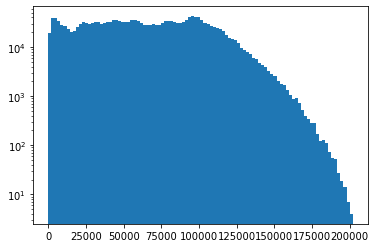

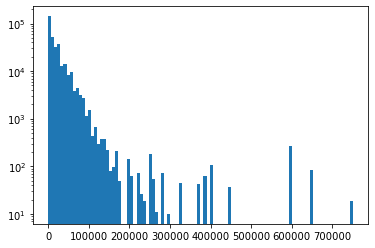

In [39]:
fig, ax = plt.subplots()
ax.hist(sams_distance_matrix.replace(np.inf, -10000).values.flatten(), 100, log=True)
_, ax = plt.subplots()
ax.hist(upsampled_resfil_tours['rf7_km']*1000, 100, log=True)

In [40]:
sams_distance_matrix.head()

SAMSCODE  12140001  12140002  12140003  12140004  12140005  12140006  \
SAMSCODE                                                               
12140001    2634.1    7727.8    4406.6    2634.1   19717.9   12549.6   
12140002    7727.8    2829.8    2829.8    4573.8   14275.9    7107.7   
12140003    4378.1    2829.8    1772.5    1743.9   17105.8    9937.5   
12140004    2634.1    4602.3    1772.5    1743.9   18878.2   11710.0   
12140005   19717.9   14275.9   17105.8   18849.7    7168.3    7168.3   

SAMSCODE  12140007  12140008  12140009  12140010  12140011  12140012  \
SAMSCODE                                                               
12140001   11889.7    5124.7    4382.2    3193.3    6663.4    6663.4   
12140002   13767.8    9665.6   11924.7    6770.5   10411.4   10411.4   
12140003   16597.6    8785.0    8760.2    3940.7    7581.6    7581.6   
12140004   14523.8    7758.9    7016.3    2854.9    6495.8    6495.8   
12140005   14076.5   18098.0   23914.8   21046.4   24687.4   24687.4   

SAMSCODE  12140013  12140014  12140015  12140016  12140017  12300003  \
SAMSCODE                                                               
12140001   25433.3   21570.0   19564.0   16224.7    9934.6   35978.4   
12140002   17705.5   20480.0   18474.0   15134.7    9901.2   39726.4   
12140003   20535.3   18706.8   16700.8   13361.5    7071.4   36896.6   
12140004   22307.8   18935.9   16929.9   13590.6    7300.5   35810.8   
12140005    8207.0   18964.3   22801.4   19462.1   22046.0   54002.4   

SAMSCODE  12300004  12300005  12300006  12300007  12300008  12300009  \
SAMSCODE                                                               
12140001   49912.1   38214.1   46863.9   42185.1   46385.4   51339.4   
12140002   43128.2   41962.1   46974.9   45933.2   50133.4   44884.1   
12140003   40298.4   39132.3   44145.1   43103.4   47303.6   42054.3   
12140004   39212.6   38046.5   49498.0   42017.6   46217.8   40968.5   
12140005   57404.1   56238.0   66396.5   60209.1   64409.4   59160.1   

SAMSCODE  12300010  12300011  12300012  12310002  12310003  12310004  \
SAMSCODE                                                               
12140001   35837.9   34218.7   34782.5   42081.0   42476.3   43435.4   
12140002   39585.9   37966.8   38530.6   42192.1   42587.4   43546.5   
12140003   36756.1   35136.9   35700.7   39362.3   39757.5   40716.7   
12140004   35670.3   34051.2   34614.9   44715.2   45110.4   46069.5   
12140005   53861.9   52242.7   52806.5   61613.6   62008.9   62968.0   

SAMSCODE  12310005  12310006  12310007  12310008  12330001  12330002  \
SAMSCODE                                                               
12140001   40538.8   43200.6   43832.1   45404.9   63315.7   62956.5   
12140002   40095.6   43135.0   40193.6   45516.0   63426.8   63067.5   
12140003   37265.8   40305.2   37363.8   42686.1   60596.9   60237.7   
12140004   43172.9   39219.4   36278.0   48039.0   65949.8   65590.6   
12140005   54371.6   57411.0   54469.5   64937.5   82848.3   82489.1   

SAMSCODE  12330003  12330004  12330005  12330006  12330007  12330008  \
SAMSCODE                                                               
12140001   63659.6   67513.6   67062.6   64799.0   79929.7   80658.6   
12140002   63770.7   67624.7   67173.7   64910.0   80040.8   80769.7   
12140003   60940.8   64794.8   64343.9   62080.2   77211.0   77939.8   
12140004   66293.7   70147.7   69696.7   67433.1   82563.8   83292.7   
12140005   83192.2   87046.2   86595.2   84331.6   99462.3  100191.2   

SAMSCODE  12330009  12330010  12330011  12330012  12330013  12330014  \
SAMSCODE                                                               
12140001   74547.2   81106.8   79843.2   69572.3   71422.5   72024.7   
12140002   74658.2   81217.9   79954.2   69683.4   71533.6   72135.7   
12140003   71828.4   78388.1   77124.4   66853.6   68703.8   69305.9   
12140004   77181.3   83741.0   82477.3   72206.5   74056.7   74658.8   
12140005   94079.8  100639.4   99

In [41]:
target_x_sams = all_x_sams.loc[1200:1264].append([all_x_sams.loc[1266:1269], all_x_sams.loc[1271:1299],
                                                  all_x_sams.loc[12650000:12659999],all_x_sams.loc[12700000:12709999],])

In [42]:
# pred_prod_sams = pd.DataFrame(production_model.predict(scaler_prod.transform(target_x_sams.loc[:, x_prod.columns])), index=target_x_sams.index, columns=['predicted_production']).sort_index()
# pred_attr_sams = pd.DataFrame(attraction_model.predict(scaler_att.transform(target_x_sams.loc[:, x_att.columns])), index=target_x_sams.index, columns=['predicted_attraction']).sort_index()

# pred_attr_sams_b = pred_attr_sams * (pred_prod_sams.sum().values / pred_attr_sams.sum().values)

In [43]:
# pred_prod_kommun = all_x_sams.loc[1200:1299].sort_index()
# pred_prod_kommun = pd.DataFrame(production_model.predict(scaler_prod.transform(pred_prod_kommun.loc[:, x_prod.columns])), index=pred_prod_kommun.index, columns=['predicted_production']).sort_index()
# pred_attr_kommun = all_x_sams.loc[1200:1299].sort_index()
# pred_attr_kommun = pd.DataFrame(attraction_model.predict(scaler_att.transform(pred_attr_kommun.loc[:, x_att.columns])), index=pred_attr_kommun.index, columns=['predicted_attraction']).sort_index()

### Mean trip length from RVU

In [44]:
filtered_resfil_tours = resfil_tours_raw[(resfil_tours_raw.rf1_Samskod > 1) & (resfil_tours_raw.rf4_Samskod > 1)]
filtered_resfil_tours.loc[:,'rf6_ankomsttid'] = filtered_resfil_tours.loc[:,'rf6_ankomsttid'].replace({'99':np.NaN})
filtered_resfil_tours = filtered_resfil_tours.dropna(subset=['rf2_starttid','rf6_ankomsttid', 'rf7_km'])
t1 = filtered_resfil_tours.rf2_starttid.apply(lambda t: datetime.datetime.strptime(t.strip(),'%H:%M'))
t2 = filtered_resfil_tours.rf6_ankomsttid.apply(lambda t: datetime.datetime.strptime(t.strip(),'%H:%M'))
t = t2-t1
t= t.apply(lambda x: x.seconds /60/60)
speed = filtered_resfil_tours.rf7_km / (t)
filtered_resfil_tours['speed'] = speed
filtered_resfil_tours = filtered_resfil_tours[filtered_resfil_tours.speed <= 70]
upsampled_resfil_tours = draw_population(filtered_resfil_tours, filtered_resfil_tours.individvikt.astype(int))

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [45]:
f = sams_distance_matrix.values
bins = [-1, 7001, 19001, 30001, 50001, 10000000000]
binned_distances = np.digitize(f.flatten(), bins).reshape(len(f),len(f))
observed_tld, _ = np.histogram(filtered_resfil_tours.rf7_km * 1000, bins)
observed_tld = observed_tld / (sum(observed_tld) / pred_prod_sams.sum().sum())
observed_tld

array([160131.59937412, 102351.35994728,  75933.12213447,  27808.6713819 ,
        13054.62628762])

In [46]:
a = 227789 - observed_tld[0]
observed_tld[0] = 227789 + 80000
# observed_tld[1] = observed_tld[1] - a
# observed_tld[2] = observed_tld[2]
observed_tld = observed_tld / (sum(observed_tld) / pred_prod_sams.sum().sum())
observed_tld

array([221540.84760743,  73670.62187568,  54655.26136135,  20016.16896245,
         9396.47931848])

In [47]:
observed_tld.sum()

379279.37912539067

In [48]:
prodA = pred_prod_sams.values.flatten()
attrA = pred_att_sams.values.flatten()
f = sams_distance_matrix.values
num_iter=100
num_iter_cal = 200
num_zones = len(prodA)
f = f
alpha = 0.5

# bins = [0., 12000 ,20000,50000,1000000]
# # bins = [_ for _ in range(0, 100000, 7000)]+[1000000]
# binned_distances = np.digitize(f.flatten(), bins).reshape(len(f),len(f))
# observed_tld, _ = np.histogram(upsampled_resfil_tours.rf7_km * 1000, bins)
# observed_tld = observed_tld / (sum(observed_tld) / pred_prod_kommun.sum().sum())

cost_matrix = np.ones([len(f), len(f)])

trips = np.zeros((num_zones, num_zones))
print('Checking production, attraction balancing:')
sumP = sum(prodA)
sumA = sum(attrA)
print('Production: ', sumP)
print('Attraction: ', sumA)
if sumP != sumA:
    print('Productions and attractions do not balance, attractions will be scaled to productions!')
    attrA = attrA * (sumP / sumA)
    attrT = attrA.copy()
    prodT = prodA.copy()
else:
    print('Production, attraction balancing OK.')
    attrT = attrA.copy()
    prodT = prodA.copy()

trips = cost_matrix*f
#Run 2D balancing --->
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
trips = trips.round(0)

for Iter in range(0, num_iter_cal):

    for i in range(0, 20):
        computed_attractions = trips.sum(0)
        computed_attractions[computed_attractions==0]=1
        trips = trips * (attrT / computed_attractions)
        trips = trips.round(0)

        computed_productions = trips.sum(1)
        computed_productions[computed_productions==0]=1
        trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
        trips = trips.round(0)

    modelled_tld = np.array([sum(trips[binned_distances == i]) for i in range(1, len(bins))])
    coeff = modelled_tld/observed_tld
    cn = []
    for c in coeff:
        if c > 1:
            cn.append(1+1/c*alpha)
        elif c < 1:
            cn.append(1-c*alpha)
        else:
            cn.append(1)
    coeff = cn
    matrix_c = np.zeros([len(f), len(f)])
    for i in range(1,len(bins)):
        matrix_c += np.array(binned_distances==i)*coeff[i-1]
    cost_matrix = cost_matrix / matrix_c
    trips = cost_matrix * f
    trips = trips.round(0)
    print(modelled_tld.astype(int))

for i in range(0, 200):
    computed_attractions = trips.sum(0)
    computed_attractions[computed_attractions==0]=1
    trips = trips * (attrT / computed_attractions)
    trips = trips.round(0)

    computed_productions = trips.sum(1)
    computed_productions[computed_productions==0]=1
    trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
    trips = trips.round(0)
    
print(modelled_tld.astype(int))
print('observed tld')
print(observed_tld.astype(int))

Checking production, attraction balancing:
Production:  379279.37912539113
Attraction:  373030.3941878543
Productions and attractions do not balance, attractions will be scaled to productions!
[    28   8150  34578  39056 300386]
[    15   8012  52459  20898 303143]
[     3   4736  92878   8617 274849]
[     8   6896  72958  14994 288688]
[     9  10209  46714  38174 287433]
[     3   6891  87731  18659 267182]
[     7   8585  50416  63946 256483]
[     0   5438 115184  33569 222350]
[     0   8449  98368  26450 245784]
[    26  12668  81358  17580 269355]
[     5  15631  46012  58758 260132]
[     0  12501 100002  31324 233607]
[    20  18420  81384  23227 257497]
[    62  28449  60284  14519 277995]
[    55  47539  26515  37255 269563]
[    31  76018  34492  19824 248994]
[     5  27725  60264  61630 234464]
[    31  53001  33310  52025 243452]
[    13  96959  45828  29821 201702]
[     3  34306 138986  13467 180727]
[     0  62018 100101  33282 182941]
[     1 156269  47625  18807 1

In [49]:
[cost_matrix[binned_distances == i][0] for i in range(1,6)]

[60382.95951338315,
 5328.6240744076695,
 1040.436925915771,
 355.45777858207543,
 25.072107470786314]

In [50]:
trips = pd.DataFrame(trips.astype(int), columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
trips.head()

SAMSCODE,12140001,12140002,12140003,12140004,12140005,12140006,12140007,12140008,12140009,12140010,12140011,12140012,12140013,12140014,12140015,12140016,12140017,12300003,12300004,12300005,12300006,12300007,12300008,12300009,12300010,12300011,12300012,12310002,12310003,12310004,12310005,12310006,12310007,12310008,12330001,12330002,12330003,12330004,12330005,12330006,12330007,12330008,12330009,12330010,12330011,12330012,12330013,12330014,12330015,12330016,12330017,12330018,12330019,12330020,12330021,12330022,12330023,12330024,12330025,12560001,12560002,12560003,12560004,12560005,12560006,12560007,12560008,12560009,12560010,12560011,12560012,12570001,12570002,12570003,12570004,12570005,12570007,12570009,12600001,12600002,12600003,12600004,12600005,12600006,12600007,12600008,12600009,12610001,12610002,12610003,12610004,12610005,12610006,12610007,12610008,12610009,12610010,12610011,12610012,12610013,12610014,12610015,12610016,12610017,12610018,12610019,12610020,12610021,12610022,12610023,12620001,12620002,12620003,12620004,12620005,12620006,12620007,12620008,12620009,12620010,12620011,12620012,12620013,12620014,12620015,12620016,12620017,12620018,12620019,12620020,12630002,12630003,12630004,12630005,12630007,12630008,12630009,12630010,12630011,12630012,12630013,12630014,12630015,12630016,12630017,12630018,12630019,12640001,12640002,12640003,12640004,12640005,12640006,12640007,12640008,12640009,12640010,12640011,12640012,12640013,12640014,12640015,12640016,12650001,12650002,12650003,12650004,12650005,12650006,12650007,12650008,12650009,12650010,12650011,12650012,12650013,12650014,12650015,12650016,12650017,12660001,12660002,12660003,12660004,12660005,12660006,12660007,12660008,12660009,12660010,12660011,12660012,12660013,12660014,12670001,12670002,12670003,12670004,12670005,12670006,12670007,12670008,12670009,12670010,12670011,12700001,12700002,12700003,12700004,12700005,12700006,12700007,12700008,12700009,12700010,12700011,12700012,12700013,12700014,12700015,12700016,12700017,12700018,12700019,12700020,12720001,12720002,12720003,12720004,12720005,12720006,12720007,12720008,12720009,12720010,12720011,12720012,12730001,12730002,12730003,12730004,12730005,12730006,12730007,12730008,12730009,12730010,12730011,12730012,12750001,12750002,12750003,12750004,12750005,12760001,12760002,12760003,12760004,12760005,12760006,12760007,12760008,12760009,12760010,12760011,12760012,12760013,12760014,12760015,12760016,12760017,12770002,12770003,12770004,12770005,12770006,12770007,12770008,12770009,12770010,12770011,12770012,12770013,12770014,12770015,12770016,12780001,12780002,12780003,12780004,12780005,12780006,12780007,12780009,12780010,12780011,12800002,12800003,12800004,12800005,12800006,12800007,12800008,12800009,12800010,12800011,12800012,12800013,12800014,12800015,12800016,12800017,12800018,12800019,12800020,12800021,12800022,12800023,12800024,12800025,12800026,12800027,12800028,12800029,12800030,12800031,12800032,12800033,12800034,12800035,12800036,12800037,12800038,12800039,12800041,12800043,12800044,12800045,12800046,12800047,12800048,12800049,12800050,12800051,12800052,12800053,12800054,12800055,12800056,12800057,12800058,12800059,12800060,12800061,12800062,12800063,12800064,12800065,12800066,12800067,12800068,12800069,12800070,12800071,12800072,12800074,12800075,12800076,12800077,12800078,12800079,12800080,12800081,12800082,12800083,12800084,12800085,12800086,12800087,12800088,12800089,12800090,12800091,12800092,12800093,12800094,12800095,12800096,12800097,12800098,12800099,12800100,12800101,12800102,12800103,12800104,12800105,12800106,12800107,12800108,12800109,12800110,12800111,12800112,12800113,12800114,12800115,12800116,12800117,12800118,12800119,12800120,12800121,12800122,12800123,12800124,12800125,12800126,12800127,12800128,12800130,12800131,12800132,12800133,12800134,12800135,12800136,12800137,12800138,12800139,12800140,12800141,12800142,12800143,12800144,12800145,12800146,12800147,12800148,12800149,12800150,12800151,12800152,1280

In [51]:
trips.sum().sum()

382834

In [52]:
sum(observed_tld)

379279.37912539067

### All trips after gravity vs predicted attraction / production

In [53]:
tours_incomming_from_external = \
    upsampled_resfil_tours[((upsampled_resfil_tours['rf1_komkod'] > 2000) | 
                            (upsampled_resfil_tours['rf1_komkod'] < 100) )
                          ].groupby('rf4_komkod')['Id'].count().loc[1200:1299]
tours_outgoing_from_external = \
    upsampled_resfil_tours[((upsampled_resfil_tours['rf4_komkod'] > 2000) | 
                            (upsampled_resfil_tours['rf4_komkod'] < 100) )
                          ].groupby('rf1_komkod')['Id'].count().loc[1200:1299]

In [54]:
def get_kommun(trips, code):
    scode = code*10000
    ecode = code*10000 + 9999
    return pd.DataFrame([[trips.loc[scode:ecode, 12000000:12990000].sum().sum() - trips.loc[scode:ecode, scode:ecode].sum().sum(),
                         trips.loc[12000000:12990000, scode:ecode].sum().sum() - trips.loc[scode:ecode, scode:ecode].sum().sum(),
                         trips.loc[scode:ecode, scode:ecode].sum().sum()
                        ]], index=[code], columns=['outgoing', 'incomming', 'within'])

In [55]:
gravity_tours = pd.concat([get_kommun(trips, code) for code in kommun_to_sams.index.values])

In [56]:
gravity_tours['outgoing'] = gravity_tours['outgoing'] + tours_outgoing_from_external.reindex(index=gravity_tours.index, fill_value=0)
gravity_tours['incomming'] = gravity_tours['incomming'] + tours_incomming_from_external.reindex(index=gravity_tours.index, fill_value=0)

In [57]:
gravity_tours.within.sum()

212301

In [58]:
other_trip_scb.within.sum()

227789.40889674125

In [59]:
other_trip_scb.sum()['production'].sum()

376943.0000000002

In [60]:
trips.sum().sum()

382834

In [61]:
gravity_tours.sum().sum()

553367

In [62]:
other_trip_scb.sum()[['outgoing', 'incomming', 'within']].sum()

519080.8925219132

In [63]:
pd.concat([gravity_tours, other_trip_scb], axis=1)

,outgoing,incomming,within,production,attraction,outgoing,incomming,within
1214,3499,2274,594,4183.918576,2605.663339,2611.962458,1033.707222,1571.956117
1230,6660,3934,629,7242.901303,4117.234794,5506.733658,2381.067149,1736.167645
1231,4822,5371,207,4871.825861,5380.534059,3584.633385,4093.341582,1287.192476
1233,8056,3461,2620,10507.800073,5538.229256,7291.556571,2321.985753,3216.243503
1256,2834,2061,1191,4092.472738,3159.551428,1897.121007,964.199697,2195.351731
1257,1827,1876,1075,2904.328485,2530.291117,1244.836328,870.798960,1659.492156
1260,3470,3025,756,4306.860010,3130.227941,2633.031927,1456.399857,1673.828083
1261,7523,4097,1977,9405.236960,5173.966383,6505.035485,2273.764908,2900.201476
1262,6068,3200,982,6822.597989,3601.575844,5277.576037,2056.553892,1545.021951
1263,5973,3329,684,6524.367265,4400.260747,4674.598259,2550.491741,1849.769006


In [64]:
(gravity_tours.within - other_trip_scb.within)

1214    -977.956117
1230   -1107.167645
1231   -1080.192476
1233    -596.243503
1256   -1004.351731
1257    -584.492156
1260    -917.828083
1261    -923.201476
1262    -563.021951
1263   -1165.769006
1264    -609.948897
1265   -1079.515084
1266    -947.240284
1267    -792.476131
1270    -736.738442
1272      83.546188
1273    -328.475106
1275    -587.537721
1276   -1250.938603
1277    -968.536233
1278    -138.229429
1280    7437.618496
1281   -1089.517165
1282    -636.952552
1283    -450.776347
1284    -244.160618
1285   -1678.432345
1286     174.533825
1287    -760.581914
1290     104.537959
1291    -293.824179
1292   -1297.688239
1293    -476.851931
Name: within, dtype: float64

In [65]:
(other_trip_scb[['incomming', 'outgoing', 'within']] / gravity_tours).describe()

,incomming,outgoing,within
count,33.000000,33.000000,33.000000
mean,0.659631,0.829151,1.661094
std,0.221029,0.129431,0.974849
min,0.433346,0.576451,0.900024
25%,0.512614,0.743391,1.069940
50%,0.579758,0.826837,1.474668
75%,0.758191,0.924653,1.843284
max,1.493617,1.159054,6.218321


In [66]:
(other_trip_scb[['outgoing', 'incomming', 'within']].loc[[1265,1270]] / gravity_tours.loc[[1265,1270]]).describe()

,outgoing,incomming,within
count,2.000000,2.000000,2.000000
mean,0.699318,0.487880,1.619192
std,0.021523,0.034980,0.078496
min,0.684099,0.463145,1.563687
25%,0.691708,0.475513,1.591439
50%,0.699318,0.487880,1.619192
75%,0.706927,0.500247,1.646944
max,0.714537,0.512614,1.674697


In [67]:
print(
    trips.loc[12650001:12650099, 12810000:12819999].sum().sum(), 'Lund\n',
    trips.loc[12650001:12659999, 12800000:12809999].sum().sum(), 'Malmö\n',
    
    trips.loc[12650001:12650099, 12640000:12649999].sum().sum(), 'Skurup\n',
    trips.loc[12650001:12650099, 12860000:12869999].sum().sum(), 'Ystad\n',
    
    trips.loc[12650001:12650099, 12700000:12709999].sum().sum(), 'Tomelilla\n',
    trips.loc[12650001:12650099, 12910000:12919999].sum().sum(), 'Simrishamn\n',
    
    trips.loc[12650001:12650099, 12850000:12859999].sum().sum(), 'Eslöv\n',
    
    trips.loc[12650001:12650099, 12670000:12679999].sum().sum(), 'Höör\n',
    trips.loc[12650001:12650099, 12660000:12669999].sum().sum(), 'Hörby\n',
)

1572 Lund
 489 Malmö
 208 Skurup
 400 Ystad
 253 Tomelilla
 168 Simrishamn
 227 Eslöv
 160 Höör
 393 Hörby



In [68]:
def count (start, end):
    start = start*10000
    end = end*10000
    return trips.loc[start:start+9999, end:end+9999].sum().sum() + trips.loc[end:end+9999, start:start+9999].sum().sum()

def count2d (start, end):
    start = start*10000
    end = end*10000
    return trips.loc[start:start+9999, end:end+9999].sum().sum(), trips.loc[end:end+9999, start:start+9999].sum().sum()

In [69]:
count2d(1286, 1291)

(616, 505)

In [70]:
print('west->sjobo')
print(
count(1280, 1265) + count(1280, 1291)*0.5 + count(1280, 1270)*0.5 + \
count(1281, 1265) + count(1281, 1291) + count(1281, 1270) + count(1281, 1286)
)

print('west->tomelilla-simrishamn')
print(
count(1280, 1291)*0.5 + count(1280, 1270)*0.5 + \
count(1281, 1291) + count(1281, 1270) + count(1281, 1286)
)
    
print('sjobo->tomelilla-simrishamn')
print(
count(1265, 1291) + count(1265, 1270)
)

print('shjobo->ystad')
print(
count(1265, 1286) +\
count(1281, 1265)
)

print('top->sjobo')
print(
count(1267, 1265) + count(1267, 1291) + count(1267, 1270) + count(1267, 1286) +\
count(1266, 1265) + count(1266, 1291) + count(1266, 1270) + count(1266, 1286)
)

print('top->tomelilla')
print(
count(1267, 1291) + count(1267, 1270) + count(1267, 1286) +\
count(1266, 1291) + count(1266, 1270) + count(1266, 1286)
)

print('west->ystad')
print(                    
count(1281, 1286)
)

print('top->ystad')
print(
count(1267, 1286)  +\
count(1266, 1286)
)

print('west->sjobo')
print(
count(1281, 1265)  +\
count(1280, 1265)
)

print('top->sjobo')
print(
count(1267, 1265) +\
count(1266, 1265)
)

print('west->sjobo')
print(
count(1280, 1265) + count(1280, 1291)*0.5 + count(1280, 1270)*0.5 + \
count(1281, 1265) + count(1281, 1291) + count(1281, 1270) + count(1281, 1286)
)

print('west->tomelilla-simrishamn')
print(
count(1280, 1291)*0.5 + count(1280, 1270)*0.5 + \
count(1281, 1291) + count(1281, 1270) + count(1281, 1286)
)



west->sjobo
3037.0
west->tomelilla-simrishamn
160.0
sjobo->tomelilla-simrishamn
1025
shjobo->ystad
2940
top->sjobo
1173
top->tomelilla
257
west->ystad
82
top->ystad
43
west->sjobo
2877
top->sjobo
916
west->sjobo
3037.0
west->tomelilla-simrishamn
160.0


In [71]:
print(
    trips.loc[12810000:12819999, 12650001:12650099].sum().sum(), 'Lund\n',
    trips.loc[12800000:12809999, 12650001:12659999].sum().sum(), 'Malmö\n',
    
    trips.loc[12860000:12869999, 12650001:12650099].sum().sum(), 'Ystad\n',
    
    trips.loc[12700000:12709999, 12650001:12650099].sum().sum(), 'Tomelilla\n',
    trips.loc[12910000:12919999, 12650001:12650099].sum().sum(), 'Simrishamn\n',
    
    trips.loc[12850000:12859999, 12650001:12650099].sum().sum(), 'Eslöv\n',
    
    trips.loc[12670000:12679999, 12650001:12650099].sum().sum(), 'Höör\n',
    trips.loc[12660000:12669999, 12650001:12650099].sum().sum(), 'Hörby\n',
)

539 Lund
 277 Malmö
 429 Ystad
 322 Tomelilla
 282 Simrishamn
 99 Eslöv
 85 Höör
 278 Hörby



In [72]:
a=0.5
for i in range(0,200):
    a -= a*0.008
    print(a)

0.496
0.49203199999999997
0.48809574399999994
0.48419097804799993
0.48031745022361594
0.476474910621827
0.4726631113368524
0.46888180644615757
0.4651307519945883
0.4614097059786316
0.45771842833080256
0.45405668090415613
0.4504242274569229
0.4468208336372675
0.4432462669681693
0.43970029683242395
0.4361826944577646
0.4326932329021025
0.42923168703888565
0.42579783354257456
0.42239145087423396
0.4190123192672401
0.41566022071310216
0.41233493894739737
0.4090362594358182
0.4057639693603316
0.40251785760544895
0.39929771474460535
0.3961033330266485
0.3929345063624353
0.38979103031153584
0.38667270206904353
0.38357932045249116
0.3805106858888712
0.3774666004017602
0.3744468675985461
0.3714512926577577
0.36847968231649564
0.3655318448579637
0.3626075900991
0.35970672937830717
0.3568290755432807
0.35397444293893443
0.35114264739542295
0.3483335062162596
0.3455468381665295
0.34278246346119723
0.34004020375350763
0.3373198821234796
0.3346213230664917
0.3319443524819598
0.3292887976621041
0.326

In [73]:
a

0.10030080882260653

In [74]:
trips.to_csv('data/od_vehits_sams_based.csv', index=True, header=True)